# Data Cleaning and Processing

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# Add pipelines to path for python modules
import sys; sys.path.insert(0, '../pipelines')

import data_processing.profile as dpprof
import data_processing.portfolio as dpport
import data_processing.transcript as dptran
import data_processing.util as util

%load_ext autoreload
%autoreload 2

## Dataset overview

There are three datasets which simulates how people make purchasing decisions and how those decisions are influenced by promotional offers. 

- Portfolio dataset contains offer meta data such as offer type and duration.
- Profile dataset captures demographic information of customers. 
- Transcript records customer's interactions with these offer. 

## Portfolio

Containing offer ids and meta data about each offer (duration, type, etc.).

portfolio.json
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [2]:
# read in the json files
portfolio = pd.read_json('../data/0_raw/portfolio.json', orient='records', lines=True)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


### Process channels column

`Channels` column is a list and the task is to make a one hot encoding for each of the channels. In addtion, add a column to indicate the total number of channels that an offer was offered on.

In [4]:
def process_channels_data(df, col='channels'):
    ''' Get the unique channels 
    
    INPUT:
    df - (pandas dataframe) input data
    
    OUTPUT:
    channels_df - (pandas dataframe) with each channel as a seperate column and total channel count
    
    '''
    
    #Exract unique channels
    channs = set()
    for chan in df[col]:
        channs.update(set(chan))
    channs = list(channs)
    
    new_channs = pd.DataFrame()
    for column in channs:
        new_channs[f'{column}_ch'] = df[col].apply(lambda x: 1 if column in x else 0)
        new_channs['num_channels'] = df[col].apply(lambda x: len(x))
    
    return new_channs

In [5]:
# Split channels into their own column and add a channels count column
new_channs = process_channels_data(portfolio)

In [6]:
new_channs.columns

Index(['email_ch', 'num_channels', 'social_ch', 'web_ch', 'mobile_ch'], dtype='object')

In [7]:
new_channs.head()

,email_ch,num_channels,social_ch,web_ch,mobile_ch
0,1,3,1,0,1
1,1,4,1,1,1
2,1,3,0,1,1
3,1,3,0,1,1
4,1,2,0,1,0


### Process offer_type column

Column `offer_type` indicates the type of the offer. Do we have missing data?

In [8]:
# add dummy fields for offer_type
portfolio['offer_type'].isnull().sum()

0

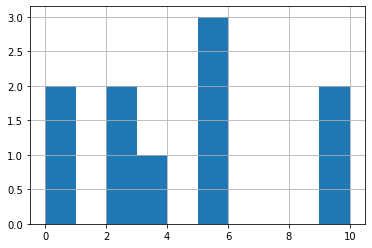

In [9]:
# reward distribution
portfolio['reward'].hist();

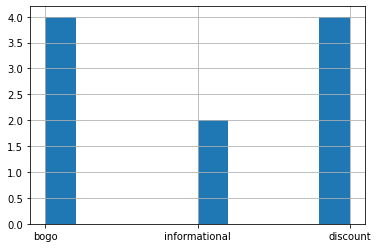

In [10]:
# offer_type 
portfolio['offer_type'].hist();

### Concatenate the new columns to Portfolio

In [11]:
new_portfo = pd.concat([portfolio, new_channs], axis=1)
new_portfo.head()

,reward,channels,difficulty,duration,offer_type,id,email_ch,num_channels,social_ch,web_ch,mobile_ch
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,3,1,0,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,4,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,3,0,1,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,3,0,1,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,2,0,1,0


### Convert duration into hours 

Duration is the valid period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. In the data set, informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement. The task is to convert the duraiton into hours to facilate data joining later on.

In [12]:
portfolio[portfolio['offer_type'] == 'informational']

,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


### Putting all steps together

In [13]:
new_portfo = dpport.process(portfolio)
new_portfo.shape

(10, 12)

In [14]:
new_portfo[:new_portfo.shape[0]]

,offer_reward,difficulty,duration,offer_id,email_ch,num_channels,social_ch,web_ch,mobile_ch,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,1,3,1,0,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,4,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,3,0,1,1,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,3,0,1,1,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,2,0,1,0,0,1,0
5,3,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,4,1,1,1,0,1,0
6,2,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,4,1,1,1,0,1,0
7,0,0,72,5a8bc65990b245e5a138643cd4eb9837,1,3,1,0,1,0,0,1
8,5,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,4,1,1,1,1,0,0
9,2,10,168,2906b810c7d4411798c6938adc9daaa5,1,3,0,1,1,0,1,0


## Profile

Profile contains demographic data for each customer.

profile.json
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

**Major data processing tasks**

- Renaming `id` column to customer_id.
- Applying OneHotEncoding to feature `gender`.
- Bucketizing 'age' into age groups by 10s, and apply one-hot encoding.
- Creating additional features based on `became_member_year` to break out year and month when customers became members. 
- Converting `income` into income groups by 10k. 


There are a group of customers who has age = 118, based on inspection, this is an anomalous group and the data will be removed.

In [15]:
profile = pd.read_json('../data/0_raw/profile.json', orient='records', lines=True)

In [16]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [17]:
profile.shape

(17000, 5)

#### Check on missing data
There are 12% of data missing for `income` column.

In [18]:
profile.isna().sum()/profile.shape[0] * 100

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

There are 12% of missing data for gender and income column.

#### Handle the missing data in gender column

There are 4 categories of gender: 'F', 'M', 'O' and None. Put unknwon if gender is missing or with value 'O'. then encode it as one-hot.

In [19]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [20]:
# number of records with gender as 'O'
profile[profile['gender']=='O'].shape[0], profile[profile['gender']=='O'].head()

(212,
     gender  age                                id  became_member_on   income
 31       O   53  d1ede868e29245ea91818a903fec04c6          20170916  52000.0
 273      O   60  d0be9ff460964c3398a33ad9b2829f3a          20180216  94000.0
 383      O   49  0d0a9ca9281248a8a35806c9ae68f872          20171207  42000.0
 513      O   63  01f46a5191424005af436cdf48a5da7c          20150920  89000.0
 576      O   73  644ac06dc9b34a5bbd237a465cf47571          20180316  88000.0)

In [22]:
# combine the steps of handling missing data and one-hot encoding
genders_encoded = dpprof.encode_gender(profile)
new_profile = pd.concat([profile, genders_encoded], axis=1)
new_profile.head()

,gender,age,id,became_member_on,income,F,M,O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,0,0,0


#### Process become_member_on column

we can build a feature to reveal whether a customer is new or long term. Since we don't know the start time of the study so we'll use current time to subtract data from `membership_length` for membership duration. In addtion, we extract `year` and `month` from this column to store information when customers became members, and finally apply one-hot encoding.

In [24]:
# joining date for newest memember
profile['became_member_on'].max()

20180726

#### Customer with age = 118

There are a group of customers having an odd age of 118. The gender and income data are also missing from this group. Logically, we drop the records.

In [25]:
# find the total number records of these anomalous data 
long_lived_customers = profile[profile['age'] == 118]
long_lived_customers.shape

(2175, 5)

In [26]:
long_lived_customers[:10]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,20150919,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,20170801,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,20170907,NaN


### Combine all processing steps together

In [27]:
new_profile = dpprof.process(profile)
new_profile.shape 

(14825, 51)

In [28]:
new_profile.head()

,gender,age,customer_id,became_member_on,income,became_member_on,became_member_year,became_member_month,membership_length,became_member_year_2013,...,income_40K,income_50K,income_60K,income_70K,income_80K,income_90K,income_100K,income_110K,income_120K,income_130K
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,20170715,2017,7,1514,0,...,0,0,0,0,0,0,0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,20170509,2017,5,1581,0,...,0,0,0,0,0,0,1,0,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,20180426,2018,4,1229,0,...,0,0,0,1,0,0,0,0,0,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,20180209,2018,2,1305,0,...,0,1,0,0,0,0,0,0,0,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,20171111,2017,11,1395,0,...,0,1,0,0,0,0,0,0,0,0


In [113]:
def plot_bar(df,column,xlabel,ylabel,title, color='c'):
    
    """ Plots a bar chart
    
    Args:
        df : a pandas dataframe 
        column : the culumn name
        xlabel : name of xlabel
        ylabel : name of ylabel
        title : chart title
    
    """
    df[column].value_counts().plot.bar(figsize=(12,4), fontsize=12,color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

#### Customer by age groups

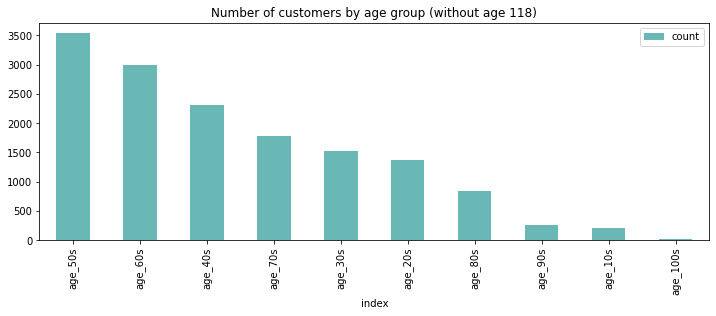

In [131]:
age_groups = new_profile[[c for c in new_profile.columns if 'age_' in c]].sum()

age_groups_df = pd.DataFrame(age_groups, columns=['count'], index=age_groups.name).reset_index()
age_groups_df.sort_values('count', ascending=False, inplace=True)
age_groups_df.plot(kind='bar', x='index', y='count', title='Number of customers by age group (without age 118)', figsize=(12,4), color='#69b8b6');

Most costumers are between 40 and 80 years with age 50 as the biggest group. 

#### Customer by membership year

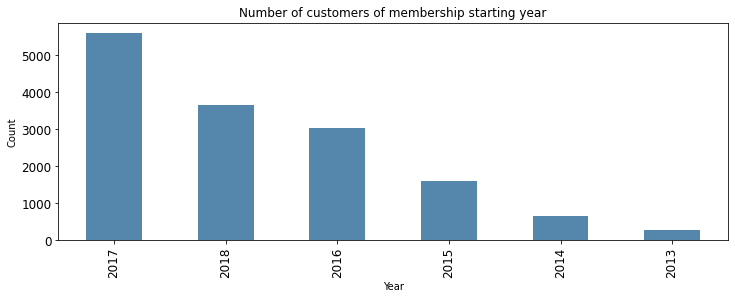

In [129]:
plot_bar(new_profile,'became_member_year','Year','Count','Number of customers of membership starting year', color='#5586ab')

#### Membership by gender and year

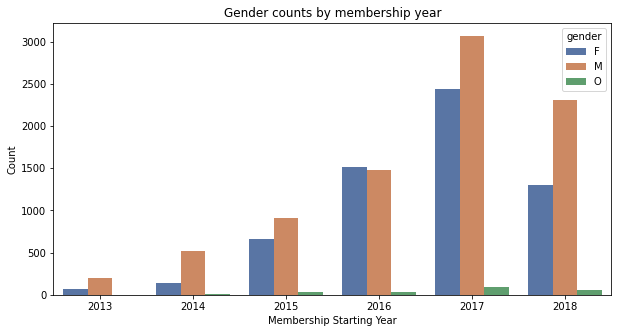

In [128]:
import seaborn as sns 

# groupby start_year and gender to plot a graph
membership_starting_year = new_profile.groupby(['became_member_year', 'gender']).size()
membership_starting_year = membership_date.reset_index()
membership_starting_year.columns = ['became_member_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='became_member_year', y='count', hue='gender', data=membership_starting_year, palette="deep")
plt.xlabel('Membership Starting Year')
plt.ylabel('Count');
plt.title('Gender counts by membership year');

Most customers started their membership in 2017. Male customers had significant growth in the year of 2017 and continue exceeding the females in year 2018.

#### Customer by income group

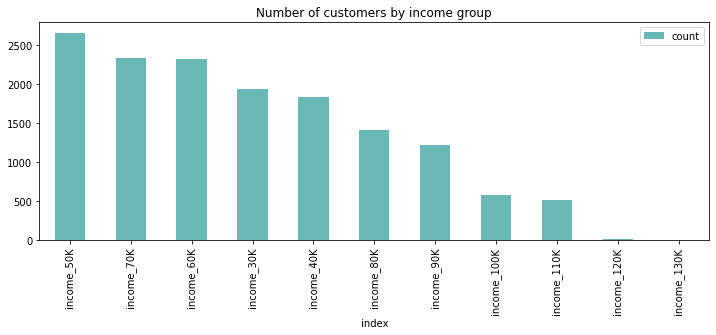

In [132]:
income_groups = new_profile[[c for c in new_profile.columns if 'income_' in c]].sum()

income_groups_df = pd.DataFrame(income_groups, columns=['count'], index=income_groups.name).reset_index()
income_groups_df.sort_values('count', ascending=False, inplace=True)
income_groups_df.plot(kind='bar', x='index', y='count', title='Number of customers by income group', figsize=(12,4), color="#69b8b6");

Most of customer are in the income buckets of 30k to 80k. There're fewer customers in the higher buckets above 100k. 

## Transcript

Transcript captures all activities and interations from customers. The raw data is from transcript.json with following schema:

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

**Main tasks**

 - Renaming `person` to customer_id.
 - Extract data from `value` field.
 - Apply one-hot encoding to event column.
 - Removing the records of customers with age 118 since those are anomalous data.

In [31]:
transcript = pd.read_json('../data/0_raw/transcript.json', orient='records', lines=True)

In [32]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Encode event column with one-hot

In [33]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [34]:
new_transcript = transcript
events = pd.get_dummies(transcript['event'])
new_transcript = pd.concat([new_transcript, events], axis=1)
new_transcript.head()

,person,event,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


### Transform value column

Value column is a dictionary with keys such as 'reward', 'amount', 'offer id' and 'offer_id'. The task is to separate the data into a set of columns.  Make offer_id column. 

In [35]:
def get_value_keys(df):
    keys = set()
    for v in df['value']:
        if v:
            keys.update(v.keys())
    return list(keys)
get_value_keys(transcript)

['amount', 'offer id', 'reward', 'offer_id']

In [36]:
offer_ids, rewards, amounts, null_value_count = dptran.process_values(transcript)
print(f'number of offers processed:{len(offer_ids)}, null values encountered: {null_value_count}')

number of offers processed:306534, null values encountered: 0


In [37]:
new_transcript['offer_id'] = offer_ids

In [38]:
new_transcript['reward'] = rewards

In [39]:
new_transcript['amount'] = amounts

In [40]:
new_transcript = new_transcript.drop('value', axis=1)
new_transcript.head()

,person,event,time,offer completed,offer received,offer viewed,transaction,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


### Put steps together

In [41]:
new_transcript = dptran.process(transcript)
new_transcript.head()

,customer_id,event,time,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,0,1,0,0


In [42]:
# retrieve a few records with view time not zero
transcript[(transcript['time']>10) & (transcript['event'] != 'offer received')].head()

,person,event,value,time
18067,8ec6ce2a7e7949b1bf142def7d0e0586,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},12
18068,f082d80f0aac47a99173ba8ef8fc1909,transaction,{'amount': 5.47},12
18069,f082d80f0aac47a99173ba8ef8fc1909,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,12
18070,102e9454054946fda62242d2e176fdce,transaction,{'amount': 14.35},12
18071,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 4.5600000000000005},12


## Create offer-response dataset

This is the most signfication step for the data processing where we combine transcript, portfolio datasets and produce new dataset grouped by customer and offer. 

The major objective for this project is to analyze how customer responds to an offer. The analysis can't depend on the offer completed because a customer can complete an offer without receiving nor viewing offer. To process the data, two columns are created, `responded`, `purchase_during_offer`. That an offer is responded is defined as following :

1. For an information offer, it is reviewed and purcahse is made during offer period.
2. For a discount or bogo offer, it is considered as responded if there are "offer completed" events and purchase made during the offer period.

The offer period is defined as time between an offer is received until an offer passes its duration. There are large number of records in the transcript dataset where the same offer has been sent to the customer. In that case, the offer starts with the first time when customer recieves it and ends when the last offer expires.

`purchase_during_offer` are the transctions recorded during the offer period.

In [51]:
# transcript
transcript_pkl_file = '../data/1_interim/transcript.pkl'
transcript_df = util.load_pkl(transcript_pkl_file)
# portfolio
portfolio_pkl_file = '../data/1_interim/portfolio.pkl'
portfolio_df = util.load_pkl(portfolio_pkl_file)
# portfolio
profile_df = util.load_pkl('../data/1_interim/profile.pkl')

### Offer-response dataset

The **dataprocessing.offer-response** module handles all the logic to create offer-response dataset.

In [52]:
offer_response_df = util.load_pkl('../data/1_interim/offer_response.pkl')
offer_response_df.shape

(63288, 68)

In [53]:
offer_response_df.head()

,customer_id,offer_id,offer_received_sum,offer_viewed_sum,offer_completed_sum,offer_reward,difficulty,duration,web_ch,num_channels,...,income_40K,income_50K,income_60K,income_70K,income_80K,income_90K,income_100K,income_110K,income_120K,income_130K
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,2,10,168,1,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,0,0,96,1,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,0,72,0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5,5,120,1,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,2,10,240,1,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


There are total 63K samples in the dataset with 68 different fields. Let's look at some of the business related question based on the data from this set. 

#### How do customers respond the offers, e.g. what is the most popular offer?

As part of producing offer-response dataset, a summary dataset (response_summary) was created based on the new dataset. This dataset reveals the responding rate from customers. 

In [54]:
response_summary_df = util.load_pkl('../data/1_interim/offer_summary.pkl')
response_summary_df

,offer_id,count,responded_count,success_rate,offer_type
9,fafdcd668e3743c1bb461111dcafc2a4,6332,4433,70.01,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6325,4313,68.19,discount
5,5a8bc65990b245e5a138643cd4eb9837,6320,4002,63.32,informational
8,f19421c1d4aa40978ebb69ca19b0e20d,6262,3655,58.37,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6330,2825,44.63,bogo
7,ae264e3637204a6fb9bb56bc8210ddfd,6374,2843,44.60,bogo
3,3f207df678b143eea3cee63160fa8bed,6331,2618,41.35,informational
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6355,2504,39.40,bogo
2,2906b810c7d4411798c6938adc9daaa5,6285,2415,38.42,discount
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6374,1472,23.09,discount


The most popular offer (fafdcd668e3743c1bb461111dcafc2a4) is a discount offer which more than 70% offer sent were responded. The least popular offer is also a discount offer(0b1e1539f2cc45b7b9fa7c272da2e1d7) which around 23% offer sent were responded. Both offers had the same duration, however the difficulty of the more popular one was a half of the other one.

#### How do offer types affect respondence ? Do customers view informational offers?

In [141]:
response_summary_df[response_summary_df['offer_type'] == 'informational']

,offer_id,count,responded_count,success_rate,offer_type
5,5a8bc65990b245e5a138643cd4eb9837,6320,4002,63.32,informational
3,3f207df678b143eea3cee63160fa8bed,6331,2618,41.35,informational


Offer types affect respondence as well as the difficulty of these offers. Based on data above, customers not only viewed the informational offers, they also made purchase during the offer. 

#### Which offer has made the most for Starbucks? What's the difference between BOGO offers and Discount offers?

#### Does income/age play a factor on completion of the offers ?

The distribution of income by gender can be viewed in following charts. The minimum and maximum incomes for both male and female are similar but the number of male customers in low-income level is higher. Also, income distribution pattern for Others is also similar to males and females. The minimum and maximum incomes are lower than the other two groups.

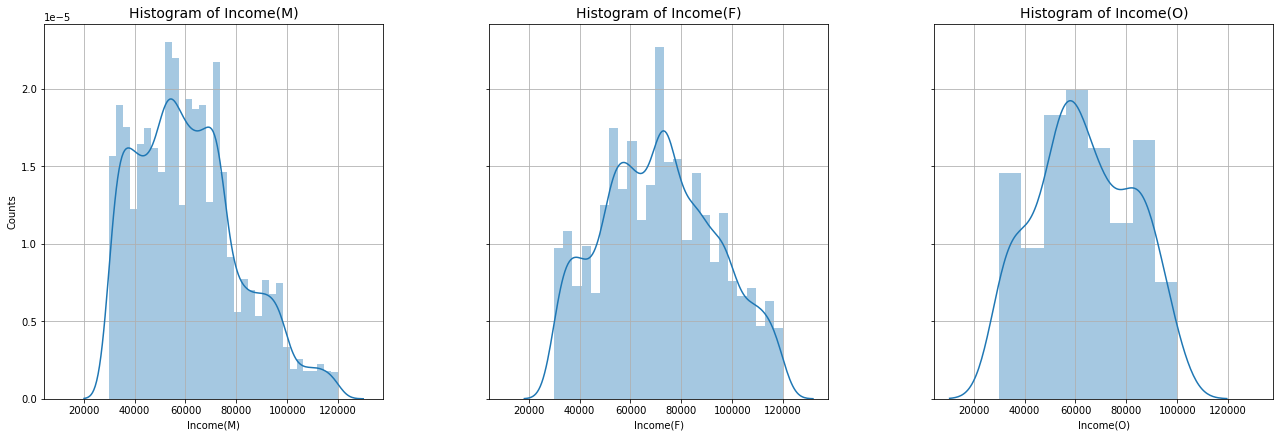

In [147]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
    # to be able to draw three subplots in a row
    fig, ax = plt.subplots(figsize=(20,8),nrows=1, ncols=3, sharex=True, sharey=True)
    fig.tight_layout(pad=9.0)

    # plot a male customers income distribution
    plt.subplot(131)
    sns.distplot(profile.loc[profile['gender'] == 'M', 'income'])
    plt.xlabel('Income(M)', fontsize=10)
    plt.ylabel('Counts', fontsize=10)
    plt.title('Histogram of Income(M)', fontsize=14)
    plt.grid(True)

    # plot a female customers income distribution
    plt.subplot(132)
    sns.distplot(profile.loc[profile['gender'] == 'F', 'income'])
    plt.xlabel('Income(F)', fontsize=10)
    plt.ylabel('Counts', fontsize=10)
    plt.title('Histogram of Income(F)', fontsize=14)
    plt.grid(True)

    # plot other customers income distribution
    plt.subplot(133)
    sns.distplot(profile[profile['gender'] == 'O']['income'])
    plt.xlabel('Income(O)', fontsize=10)
    plt.ylabel('Counts', fontsize=10)
    plt.title('Histogram of Income(O)', fontsize=14)
    plt.grid(True)

**Offer Interactions by Gender**

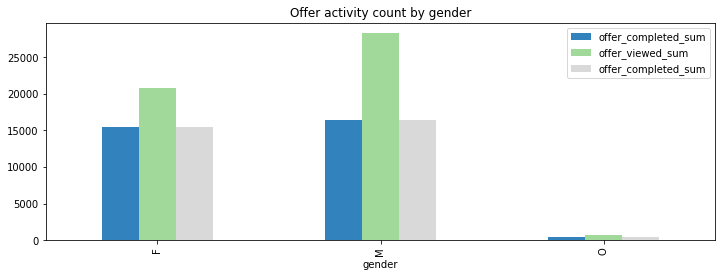

In [173]:
events_by_gender = offer_response_df[['offer_completed_sum', 'offer_viewed_sum', 'offer_completed_sum', 'gender']].groupby('gender').sum()
events_by_gender.plot(kind='bar', figsize=(12,4), cmap='tab20c', title='Offer activity count by gender');

From the chart above, Male customers were very active in terms of viewing the offer received.

**Offer Response by Gender**

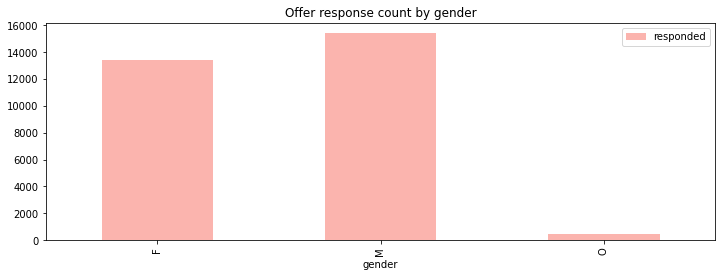

In [182]:
resp_by_gender = offer_response_df[['gender','responded']].groupby('gender').sum()
resp_by_gender.plot(kind='bar', figsize=(12,4), cmap='Pastel1', title='Offer response count by gender');

Male customers viewed lot of offers and also responded more often to these offers than femable customers.

**Offer Purchase by Gender**

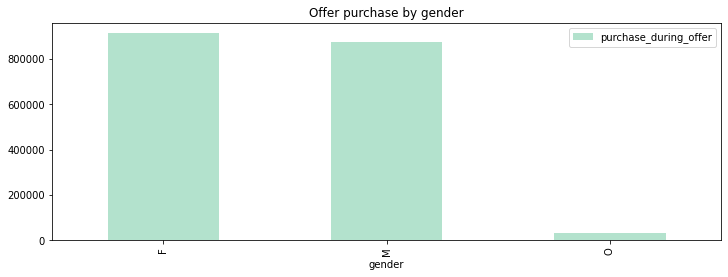

In [179]:
purchases_by_gender = offer_response_df[['gender', 'purchase_during_offer']].groupby('gender').sum()
purchases_by_gender.plot(kind='bar', figsize=(12,4), cmap='Pastel2', title='Offer purchase by gender');

Even though Male customers were more active than female customers in terms of offer activties, in terms of money spending, female customers spent more money during the offers!